In [2]:
import pandas as pd
import urllib.request
import zipfile
import numpy as np

# MovieLens100kをダウンロードして解凍
# urllib.request.urlretrieve('http://files.grouplens.org/datasets/movielens/ml-25m.zip', '../data/ml-25m.zip')
# with zipfile.ZipFile('../data/ml-25m.zip') as zip_file:
#     zip_file.extractall('../data/')

In [3]:
from functools import wraps
import time
def stop_watch(func) :
    """
    Note
    https://qiita.com/hisatoshi/items/7354c76a4412dffc4fd7
    """
    @wraps(func)
    def wrapper(*args, **kargs) :
        start = time.time()
        result = func(*args,**kargs)
        elapsed_time =  time.time() - start
        print(f"{func.__name__}は{elapsed_time}秒かかりました")
        return result
    return wrapper

In [4]:
import random

def filter_df(ratings: pd.DataFrame, col_name: str, N: int):
    """
    指定したカラムを指定しサンプル数になるようにDataFrameを絞り込む
    """
    factor_list = list(set(ratings[col_name]))
    factor_sample = random.sample(factor_list, N)
    return ratings.query(f'{col_name} in @factor_sample').reset_index(drop=True)

In [5]:
import os
os.cpu_count()

4

In [6]:
ratings = pd.read_csv('../data/ml-25m/ratings.csv')
print(f'ユーザー数: {len(set(ratings.userId))}')

ユーザー数: 162541


In [7]:
# 計算コストを抑えるためにユーザー数を絞る
ratings_sample = filter_df(ratings, col_name='userId', N=1000)

In [9]:
ratings_sample.head()

,userId,movieId,rating,timestamp
0,126,293,4.5,1491854891
1,126,296,4.5,1491854881
2,126,318,4.5,1491854768
3,126,356,4.0,1491854771
4,126,527,5.0,1491854752


In [10]:
user_id = 126

# Content-Base Filtering

映画の属性情報をもとに特徴量を生成する。今回はジャンル名を使用する。

In [175]:
movies = pd.read_csv('../data/ml-25m/movies.csv')

In [177]:
movies = filter_df(movies, col_name='movieId', N=1000)

In [171]:
def add_onehot_genres(movies: pd.DataFrame):
    """
    genresカラムをOneHot表現に変換する
    """
    # genresカラムの文字列を'|'でlistに分割
    genres_col = movies.genres.map(lambda x: x.split('|')).to_list()
    # OneHot表現するgenresの要素のlist作成
    genre_col_name = list()
    for i in genres_col:
        genre_col_name.extend(i)
    genre_col_name = list(set(genre_col_name))
    # OneHot表現作成
    # 処理の高速化のために各行をlist化し、最後にDataFrameを作成
    rows = list()
    for index, row in enumerate(genres_col):
        row_list = np.array([0] * len(genre_col_name))
        index_list = [genre_col_name.index(item) for item in row]
        row_list[index_list] = 1
        rows.append(list(row_list))
    genre_df = pd.DataFrame(rows, columns=genre_col_name)
    return (pd.concat([movies, genre_df], axis=1), genre_col_name)

In [181]:
movies, genre_col_name = add_onehot_genres(movies)

In [277]:
class ContentBaseFiltering:
    """
    content-base filteringを実装したクラス
    """
    def __init__(self, data, item_id_name: str, feature_col_names: list):
        
        def get_itemId2index(item_id_series: pd.Series):
            itemId2index = dict()
            for num, item_id in enumerate(item_id_series):
                itemId2index[item_id] = num
            return itemId2index
        
        self.data = data
        self.item_id_name = item_id_name
        self.feature_col_names = feature_col_names
        self.itemId2index = get_itemId2index(data[item_id_name])
        
    
    def fit(self):
        c = np.array(self.data[self.feature_col_names])
        norm = np.matrix(np.linalg.norm(c, axis=1))
        np.dot(norm.T, norm)
        # 類似度行列
        self.sim_mat = np.array(np.dot(c, c.T)/np.dot(norm.T, norm))
    
    
    def recommend(self, item_id, topN: int):
        # 類似度行列で対象アイテムの行数を取得
        row_num = self.itemId2index[item_id]
        topN_index = np.argsort(self.sim_mat[row_num])[::-1][2:topN]
        sims = self.sim_mat[row_num][topN_index]
        item_id_list = self.data[self.item_id_name][topN_index]
        return [(item, sim) for item, sim in zip(item_id_list, sims)]
        

In [278]:
cbf = ContentBaseFiltering(
    data=movies, item_id_name='movieId', feature_col_names=genre_col_name)

In [279]:
cbf.fit()

In [280]:
cbf.recommend(item_id=378, topN=10)

[(51082, 0.9999999999999998),
 (54004, 0.9999999999999998),
 (169868, 0.9999999999999998),
 (177475, 0.9999999999999998),
 (79775, 0.9999999999999998),
 (88925, 0.9999999999999998),
 (179553, 0.9999999999999998),
 (205106, 0.9999999999999998)]

# User-base collaborative filtering

In [11]:
class UserBaseCollaborativeFiltering:
    """
    user-base colaborative filteringを実装したクラス
    """
    def __init__(self, data, user_id_name: str, item_id_name: str, rating_name: str):
        
        def get_userId2index(user_id_series: pd.Series):
            userId2index = dict()
            for num, user_id in enumerate(user_id_series):
                userId2index[user_id] = num
            return userId2index
        
        def get_itemId2index(item_id: pd.Series):
            itemId2index = dict()
            for num, item_id in enumerate(movies.movieId):
                itemId2index[item_id] = num
            return itemId2index
        
        self.user_id_name = user_id_name
        self.item_id_name = item_id_name
        self.rating_name = rating_name
        
        # item_idを縦持ちから横持ちに変換
        ratings_pivod = ratings_sample.pivot_table(values=[rating_name], index=[user_id_name], columns=[item_id_name], aggfunc='sum')
        # MultiIndexを解除、item_inの特徴量カラムに変更
        item_columns = [j for i, j in ratings_pivod.columns]
        ratings_pivod.columns = item_columns
        ratings_pivod = ratings_pivod.reset_index()
        
        self.data = ratings_pivod[item_columns]
        self.userId2index = get_userId2index(ratings_pivod[user_id_name])
        
    
    def fit(self):
        
        def get_similarity_matrix(ratings_pivod: pd.DataFrame):
            """
            類似度行列を作成する
            """
            ratings_array = np.array(ratings_pivod)

            size = ratings_array.shape[0]
            # 類似度行列を初期化
            sim = np.zeros((size, size))
            # 類似度行列の上三角行列を作成
            for i in range(size):
                for j in range(i, size):
                    # 評価されているindexのみを取得
                    co_eval_index = list(
                        set(np.where(~np.isnan(ratings_array[i]))[0])
                        & set(np.where(~np.isnan(ratings_array[j]))[0])
                    )
                    a = ratings_array[i][co_eval_index]
                    b = ratings_array[j][co_eval_index]
                    sim[i, j] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

            # 上三角行列 + 下三角行列
            sim_mat = sim + sim.T - np.identity(size)
            return sim_mat
        
        self.sim_mat = get_similarity_matrix(self.data)
    
    
    def recommend(self, user_id: int, topN: int):
        """
        topNをレコメンドする
        """
        
        user_index = self.userId2index[user_id]
        # 類似度行列作成
        ratings_array = np.array(self.data)
        # 未評価のindex
        non_eval_index_list = np.where(np.isnan(ratings_array[user_index]))[0]

        est_eval = list()
        for index in non_eval_index_list:
            # 未評価のindexを評価しているuserのindex
            eval_user_index = np.where(~np.isnan(ratings_array[:, index]))
            # 未評価のindexに対する評価を推定
            k = np.nansum(self.sim_mat[user_index][eval_user_index])
            sim_vec = self.sim_mat[user_index][eval_user_index]
            eval_vec = ratings_array[:, index][eval_user_index]
            est = np.nansum(sim_vec * eval_vec) / k
            if np.isnan(est):
                est_eval.append(0)
            else:
                est_eval.append(np.nansum(sim_vec * eval_vec) / k)
        # 推定した評価値を代入
        ratings_array[user_index][non_eval_index_list] = np.array(est_eval)
        higher_index = np.argsort(ratings_array[user_index])[::-1]

        col_index = list()
        sims = list()
        for i in higher_index:
            if i in non_eval_index_list:
                col_index.append(i)
                sims.append(ratings_array[user_index][i])
                if len(col_index) > topN:
                    break

        result = [(index, similarity) for index, similarity in zip(self.data.columns[col_index], sims)]
        return result
        

In [12]:
# 計算コストを抑えるためにユーザー数を絞る
ratings_sample = filter_df(ratings, col_name='userId', N=1000)

In [360]:
ubcf = UserBaseCollaborativeFiltering(
    data=ratings_sample,
    user_id_name='userId',
    item_id_name='movieId',
    rating_name='rating')

In [361]:
ubcf.fit()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


In [370]:
ubcf.recommend(user_id=122, topN=10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in double_scalars


[(96520, 5.000000000000001),
 (104636, 5.000000000000001),
 (5958, 5.000000000000001),
 (85774, 5.000000000000001),
 (34026, 5.000000000000001),
 (115998, 5.000000000000001),
 (104829, 5.000000000000001),
 (130578, 5.000000000000001),
 (5825, 5.0),
 (92335, 5.0),
 (32705, 5.0)]

**考察**  
ユーザーが未評価のアイテムに対して評価しているユーザー数がごくわずか。そのわずかな評価値が5であることが多いために、評価値の推定が偏っている。

# item-base collaborative filtering

In [17]:
# 計算コストを抑えるためにユーザー数を絞る
ratings_sample = filter_df(ratings, col_name='movieId', N=100)

In [37]:
class ItemBaseCollaborativeFiltering:
    """
    item-base colaborative filteringを実装したクラス
    """
    def __init__(self, data, user_id_name: str, item_id_name: str, rating_name: str):
        
        def get_itemId2index(item_id_series: pd.Series):
            itemId2index = dict()
            for num, item_id in enumerate(item_id_series):
                itemId2index[item_id] = num
            return itemId2index
        
        
        def get_userId2index(user_columns: list):
            userId2index = dict()
            for num, user_id in enumerate(user_columns):
                userId2index[user_id] = num
            return userId2index
        
        
        self.user_id_name = user_id_name
        self.item_id_name = item_id_name
        self.rating_name = rating_name
        
        # user_idを縦持ちから横持ちに変換
        ratings_pivod = ratings_sample.pivot_table(values=[rating_name], index=[item_id_name], columns=[user_id_name], aggfunc='sum')
        # MultiIndexを解除、item_inの特徴量カラムに変更
        user_columns = [j for i, j in ratings_pivod.columns]
        ratings_pivod.columns = user_columns
        ratings_pivod = ratings_pivod.reset_index()
        self.data = ratings_pivod[user_columns]
        self.itemId2index = get_itemId2index(ratings_pivod[item_id_name])
        self.userId2index = get_userId2index(user_columns)
        
    
    def fit(self):
        
        def get_similarity_matrix(ratings_pivod: pd.DataFrame):
            """
            類似度行列を作成する
            """
            ratings_array = np.array(ratings_pivod)

            size = ratings_array.shape[0]
            # 類似度行列を初期化
            sim = np.zeros((size, size))
            # 類似度行列の上三角行列を作成
            for i in range(size):
                for j in range(i, size):
                    # 評価されているindexのみを取得
                    co_eval_index = list(
                        set(np.where(~np.isnan(ratings_array[i]))[0])
                        & set(np.where(~np.isnan(ratings_array[j]))[0])
                    )
                    a = ratings_array[i][co_eval_index]
                    b = ratings_array[j][co_eval_index]
                    sim[i, j] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

            # 上三角行列 + 下三角行列
            sim_mat = sim + sim.T - np.identity(size)
            return sim_mat
        
        self.sim_mat = get_similarity_matrix(self.data)
    
    
    def recommend(self, user_id: int, topN: int):
        """
        topNをレコメンドする
        """
        
        user_index = self.userId2index[user_id]
        ratings_array = np.array(self.data)
        # 未評価のindex
        non_eval_index_list = np.where(np.isnan(ratings_array[user_index]))[0]

        est_eval = list()
        for index in non_eval_index_list:
            # 未評価のindexを評価しているuserのindex
            eval_user_index = np.where(~np.isnan(ratings_array[:, index]))
            # 未評価のindexに対する評価を推定
            k = np.nansum(self.sim_mat[user_index][eval_user_index])
            sim_vec = self.sim_mat[user_index][eval_user_index]
            eval_vec = ratings_array[:, index][eval_user_index]
            est = np.nansum(sim_vec * eval_vec) / k
            if np.isnan(est):
                est_eval.append(0)
            else:
                est_eval.append(np.nansum(sim_vec * eval_vec) / k)
        # 推定した評価値を代入
        ratings_array[user_index][non_eval_index_list] = np.array(est_eval)
        higher_index = np.argsort(ratings_array[user_index])[::-1]

        col_index = list()
        sims = list()
        for i in higher_index:
            if i in non_eval_index_list:
                col_index.append(i)
                sims.append(ratings_array[user_index][i])
                if len(col_index) > topN:
                    break

        result = [(index, similarity) for index, similarity in zip(self.data.columns[col_index], sims)]
        return result
        

In [34]:
ibcf = ItemBaseCollaborativeFiltering(
    data=ratings_sample,
    user_id_name='userId',
    item_id_name='movieId',
    rating_name='rating')

In [35]:
ibcf.fit()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


In [36]:
ibcf.ratings_pivod

,movieId,1,2,5,9,12,13,15,23,31,...,162516,162517,162519,162528,162529,162530,162532,162535,162538,162541
0,576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1246,NaN,4.0,5.0,4.0,4.0,NaN,5.0,5.0,1.5,...,3.0,NaN,NaN,NaN,5.0,3.0,5.0,4.0,5.0,NaN
3,2012,2.5,NaN,NaN,NaN,2.0,3.5,NaN,NaN,2.0,...,3.0,5.0,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.5
4,2436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,201504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,205373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,205433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,205933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# mobieIdを縦持ちから横持ちに変換
ratings_pivod = ratings_sample.pivot_table(values=['rating'], index=['movieId'], columns=['userId'], aggfunc='sum').reset_index(drop=True)
# MultiIndexのレベル変更
ratings_pivod.columns = ratings_pivod.columns.droplevel(0)

In [25]:
ratings_pivod.head()

userId,1,2,5,9,12,13,15,23,31,43,...,162516,162517,162519,162528,162529,162530,162532,162535,162538,162541
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,5.0,4.0,4.0,NaN,5.0,5.0,1.5,4.0,...,3.0,NaN,NaN,NaN,5.0,3.0,5.0,4.0,5.0,NaN
3,2.5,NaN,NaN,NaN,2.0,3.5,NaN,NaN,2.0,3.5,...,3.0,5.0,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.5
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
np.array(ratings_pivod).shape

(100, 39551)

In [29]:
np.array(ratings_pivod).T.shape

(39551, 100)

In [267]:
sim_mat = get_similarity_matrix(ratings_pivod)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

In [ ]:
def recommend(ratings_pivod: pd.DataFrame, user_index: int, topN: int, sim_mat):
    """
    topNをレコメンドする
    """
    # 類似度行列作成
    ratings_array = np.array(ratings_pivod)
    # 未評価のindex
    non_eval_index_list = np.where(np.isnan(ratings_array[user_index]))[0]
    
    est_eval = list()
    for index in non_eval_index_list:
        # 未評価のindexを評価しているuserのindex
        eval_user_index = np.where(~np.isnan(ratings_array[:, index]))
        # 未評価のindexに対する評価を推定
        k = np.nansum(sim_mat[user_index][eval_user_index])
        sim_vec = sim_mat[user_index][eval_user_index]
        eval_vec = ratings_array[:, index][eval_user_index]
        est = np.nansum(sim_vec * eval_vec) / k
        if np.isnan(est):
            est_eval.append(0)
        else:
            est_eval.append(np.nansum(sim_vec * eval_vec) / k)
    # 推定した評価値を代入
    ratings_array[user_index][non_eval_index_list] = np.array(est_eval)
    higher_index = np.argsort(ratings_array[user_index])[::-1]
    
    col_index = list()
    sims = list()
    for i in higher_index:
        if i in non_eval_index_list:
            col_index.append(i)
            sims.append(ratings_array[user_index][i])
            if len(col_index) > 10:
                break
    
    result = [(index, similarity) for index, similarity in zip(ratings_pivod.columns[col_index], sims)]
    return result

# Model-base collaborative filtering

SVD(singular value decomposition)によって評価値行列を分解する。指定した因子を保持するユーザー行列、アイテム行列を生成する。  
https://heartbeat.fritz.ai/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

In [372]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

class ModelBaseCollaborativeFiltering:
    """
    user-base colaborative filteringを実装したクラス
    """
    def __init__(self, data, user_id_name: str, item_id_name: str, rating_name: str, factor_num: int):
        
        def get_userId2index(user_id_series: pd.Series):
            userId2index = dict()
            for num, user_id in enumerate(user_id_series):
                userId2index[user_id] = num
            return userId2index
        
        def get_itemId2index(item_id: pd.Series):
            itemId2index = dict()
            for num, item_id in enumerate(movies.movieId):
                itemId2index[item_id] = num
            return itemId2index
        
        self.user_id_name = user_id_name
        self.item_id_name = item_id_name
        self.rating_name = rating_name
        self.k = factor_num
        
        # item_idを縦持ちから横持ちに変換
        ratings_pivod = ratings_sample.pivot_table(values=['rating'], index=['userId'], columns=['movieId'], aggfunc='sum')
        # MultiIndexを解除、item_inの特徴量カラムに変更
        item_columns = [j for i, j in ratings_pivod.columns]
        ratings_pivod.columns = item_columns
        ratings_pivod = ratings_pivod.reset_index()
        self.data = ratings_pivod[item_columns]
        self.userId2index = get_userId2index(ratings_pivod[user_id_name])
        self.data_csc = csc_matrix(self.data.fillna(0))
        
    
    def fit(self):
        # 評価値行列作成
        u, s, vt = svds(self.data_csc, k=self.k)
        self.est_eval = np.dot(np.dot(u, np.diag(s)), vt)
    
    
    def recommend(self, user_id: int, topN: int):
        """
        topNをレコメンドする
        """
        
        user_index = self.userId2index[user_id]
        # 未評価のindex list
        non_eval_index_list = np.where(np.isnan(np.array(self.data)[user_index]))[0]
        
        higher = np.argsort(self.est_eval[user_index])[::-1]
        result = list()
        for i in higher:
            if i in non_eval_index_list:
                result.append((self.data.columns[i], self.est_eval[user_index][i]))
            if len(result) > 10:
                break
        return result

In [374]:
mbcf = ModelBaseCollaborativeFiltering(
    data=ratings_sample,
    user_id_name='userId',
    item_id_name='movieId',
    rating_name='rating',
    factor_num=50)

In [375]:
mbcf.fit()

In [376]:
mbcf.recommend(user_id=122, topN=10)

[(593, 3.076705519695481),
 (153, 1.730519146419619),
 (10, 1.637079264242114),
 (208, 1.614937847916802),
 (21, 1.4447290448178416),
 (586, 1.4040336718199535),
 (225, 1.3873105292148855),
 (508, 1.2633822018112106),
 (368, 1.2413538068741357),
 (151, 1.216972554187938),
 (236, 1.1298421285815088)]

# DeepLearning

Word2Vecでレコメンドする。  
https://yolo-kiyoshi.com/2020/08/16/post-2168/

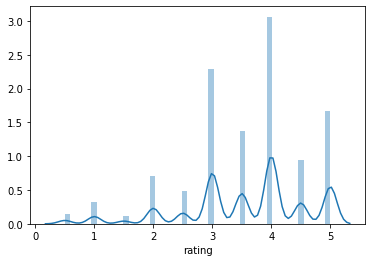

In [377]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(ratings_sample.rating)

In [397]:
from gensim.models import Word2Vec

class NNCollaborativeFiltering:
    """
    DeepLearning base colaborative filteringを実装したクラス
    """
    def __init__(
        self, data, user_id_name: str, item_id_name: str,
        rating_name: str, date_col_name: str, geq: float):
        
        def get_userId2itemList(data: pd.DataFrame, user_id_name: str, item_id_name: str):
            userId2itemList = dict()
            for i, v in data.groupby(user_id_name):
                userId2itemList[i] = v[item_id_name].to_list()
            return userId2itemList
        
        # ユーザーごとにtimestampで昇順ソート
        data.sort_values([user_id_name, date_col_name], inplace=True)
        # item_idのデータ型をstr型に変換
        data.loc[:, item_id_name] = data[item_id_name].astype('str')
        # 評価値が一定数以上のデータのみに絞り込む
        data_filtered = data.query(f'{rating_name} >= {geq}')
        self.data_filtered = data_filtered
        # 学習データ作成
        self.train = [v[item_id_name].to_list() for i,v in data_filtered.groupby('userId')]
        
        self.user_id_name = user_id_name
        self.item_id_name = item_id_name
        self.rating_name = rating_name
        self.userId2itemList = get_userId2itemList(data, user_id_name, item_id_name)
        
    
    def fit(self):
        self.model = Word2Vec(train)
    
    def recommend(self, user_id: int, topN: int):
        """
        topNをレコメンドする
        """
        def get_word2index_dict(model):
            """
            wordからindexを取得できる辞書を作成する
            """
            word2index = dict()
            for i in range(len(model.wv.vocab)):
                word2index[model.wv.index2word[i]] = i
            return word2index


        def customized_most_similar(model, positive: list, remove_index: list, word2index: dict, topN: int):
            """
            特定のwordを除外してmost_similarを出力する

            Parameters
            ----------
            model : gensim.model.Word2Vec
                word2vec学習済みモデル。
            positive : list
                加算対象のwordのlist。
            remove_index : list
                除外対象のwordのindexのlist。
            word2index : dict
                wordがkey、indexがvalueのdict。
            topN : int
                出力対象のword数。

            Returns
            -------
            result : list
                類似度topNの(word, sim)のtupleのlist。
            """

            model.wv.init_sims()
            # 加算対象のwordのベクトルを取得し、合成する
            pos = [model.wv.vectors_norm[word2index[i]] for i in positive]
            pos_sum = np.sum(np.array(pos), axis=0)
            # cosine類似度ベクトルを作成
            sim = np.dot(model.wv.vectors_norm, pos_sum)/np.linalg.norm(pos_sum)
            # 加算対象のwordを除外wordに追加
            positive_index = [word2index[i] for i in positive]
            remove_index = remove_index + positive_index
            # cosine類似度ベクトルから除外対象のwordを除外
            sim = np.delete(sim, remove_index, 0)
            # index2wordからも除外対象のwordを除外
            index2word = np.delete(np.array(model.wv.index2word), remove_index, 0)
            # 類似度topNを取得
            topn = np.argsort(sim)[::-1][:topN]

            return [(index2word[i], sim[i]) for i in topn]
        
        # word2index作成
        word2index = get_word2index_dict(self.model)
        
        # 評価済みのindex
        eval_index_set = set(self.userId2itemList[user_id])
        # 学習済みモデルのvocabに存在する
        vocab_in_model = list(self.model.wv.vocab.keys())
        eval_index_list = list(eval_index_set & set(vocab_in_model))
        
        remove_index = [word2index[i] for i in eval_index_list]
        # 直近の高評価かつモデルに存在するmovie
        trriger = self.data_filtered.query(
            f'({self.user_id_name} == {user_id}) & ({self.item_id_name} in @vocab_in_model)'
        )[self.item_id_name][-1:].to_list()
        
        return customized_most_similar(
            model=self.model,
            positive=trriger,
            remove_index=remove_index,
            word2index=word2index,
            topN=topN
        )
        

In [398]:
nncf = NNCollaborativeFiltering(
    data=ratings_sample,
    user_id_name='userId',
    item_id_name='movieId',
    rating_name='rating',
    date_col_name='timestamp',
    geq=3.0)

In [399]:
nncf.fit()

In [400]:
nncf.recommend(user_id=122, topN=10)

KeyError: 122